In [1]:
import os
import zipfile
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
# DeepWeeds: Extract ZIP and organize using Species labels (SAFE VERSION)

deepweeds_zip = r"C:\Users\VAIBHAB\DeepWeeds.zip"
raw_path = r"C:\Users\VAIBHAB\DeepWeeds_raw"
organized_path = r"C:\Users\VAIBHAB\DeepWeeds_organized"

# 1. Extract ZIP (run once)
if not os.path.exists(raw_path):
    with zipfile.ZipFile(deepweeds_zip, 'r') as z:
        z.extractall(raw_path)
    print("DeepWeeds extracted.")
else:
    print("DeepWeeds already extracted.")

# 2. Read labels.csv
labels_csv = os.path.join(raw_path, "labels", "labels.csv")
df = pd.read_csv(labels_csv)

print("CSV preview:")
print(df.head())

images_dir = os.path.join(raw_path, "images")
os.makedirs(organized_path, exist_ok=True)

# 3. Organize images into class folders (SAFE COPY)
skipped = 0
copied = 0

for _, row in df.iterrows():
    img_name = row["Filename"]
    class_name = row["Species"].strip().replace(" ", "_")

    class_dir = os.path.join(organized_path, class_name)
    os.makedirs(class_dir, exist_ok=True)

    src = os.path.join(images_dir, img_name)
    dst = os.path.join(class_dir, img_name)

    if os.path.exists(src) and not os.path.exists(dst):
        try:
            shutil.copy2(src, dst)
            copied += 1
        except PermissionError:
            skipped += 1
    else:
        skipped += 1

print(f"DeepWeeds organization complete.")
print(f"Copied files : {copied}")
print(f"Skipped files: {skipped}")


DeepWeeds already extracted.
CSV preview:
                Filename  Label       Species
0  20160928-140314-0.jpg      0  Chinee apple
1  20160928-140337-0.jpg      0  Chinee apple
2  20160928-140731-0.jpg      0  Chinee apple
3  20160928-140747-0.jpg      0  Chinee apple
4  20160928-141107-0.jpg      0  Chinee apple
DeepWeeds organization complete.
Copied files : 0
Skipped files: 17509


In [4]:
fer_zip = r"C:\Users\VAIBHAB\FER-2013.zip"
fer_path = r"C:\Users\VAIBHAB\FER-2013"

if not os.path.exists(fer_path):
    with zipfile.ZipFile(fer_zip, 'r') as z:
        z.extractall(fer_path)
    print("FER-2013 extracted.")
else:
    print("FER-2013 already extracted.")


FER-2013 already extracted.


In [5]:
deepweeds_path = r"C:\Users\VAIBHAB\DeepWeeds_organized"
fer_train_path = r"C:\Users\VAIBHAB\FER-2013\train"
fer_test_path  = r"C:\Users\VAIBHAB\FER-2013\test"


In [6]:
dw_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dw_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [7]:
dw_dataset = datasets.ImageFolder(deepweeds_path, transform=dw_train_transform)

train_size = int(0.8 * len(dw_dataset))
test_size = len(dw_dataset) - train_size

dw_train, dw_test = random_split(dw_dataset, [train_size, test_size])
dw_test.dataset.transform = dw_test_transform

train_loader_dw = DataLoader(dw_train, batch_size=32, shuffle=True)
test_loader_dw = DataLoader(dw_test, batch_size=32, shuffle=False)

num_classes_dw = len(dw_dataset.classes)
print("DeepWeeds classes:", num_classes_dw)


DeepWeeds classes: 9


In [8]:
from torchvision.models import resnet18, ResNet18_Weights

model_dw = resnet18(weights=ResNet18_Weights.DEFAULT)

for param in model_dw.parameters():
    param.requires_grad = False

model_dw.fc = nn.Linear(model_dw.fc.in_features, num_classes_dw)
model_dw = model_dw.to(device)


In [9]:
criterion_dw = nn.CrossEntropyLoss()
optimizer_dw = optim.Adam(model_dw.fc.parameters(), lr=0.001)
scheduler_dw = optim.lr_scheduler.StepLR(optimizer_dw, 5, 0.5)


In [10]:
epochs = 10

for epoch in range(epochs):
    model_dw.train()
    correct = total = 0

    for imgs, labels in train_loader_dw:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer_dw.zero_grad()
        outputs = model_dw(imgs)
        loss = criterion_dw(outputs, labels)
        loss.backward()
        optimizer_dw.step()

        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    scheduler_dw.step()
    print(f"Epoch {epoch+1}: Accuracy = {correct/total:.4f}")


Epoch 1: Accuracy = 0.6361
Epoch 2: Accuracy = 0.7237
Epoch 3: Accuracy = 0.7412
Epoch 4: Accuracy = 0.7560
Epoch 5: Accuracy = 0.7593
Epoch 6: Accuracy = 0.7706
Epoch 7: Accuracy = 0.7750
Epoch 8: Accuracy = 0.7802
Epoch 9: Accuracy = 0.7798
Epoch 10: Accuracy = 0.7750


In [11]:
model_dw.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader_dw:
        outputs = model_dw(imgs.to(device))
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=dw_dataset.classes))


                precision    recall  f1-score   support

  Chinee_apple       0.73      0.57      0.64       235
       Lantana       0.69      0.54      0.61       190
      Negative       0.82      0.90      0.86      1848
   Parkinsonia       0.82      0.78      0.80       199
    Parthenium       0.72      0.58      0.64       205
Prickly_acacia       0.73      0.81      0.77       220
   Rubber_vine       0.73      0.76      0.74       185
     Siam_weed       0.84      0.64      0.73       205
    Snake_weed       0.63      0.56      0.60       215

      accuracy                           0.78      3502
     macro avg       0.75      0.68      0.71      3502
  weighted avg       0.78      0.78      0.78      3502



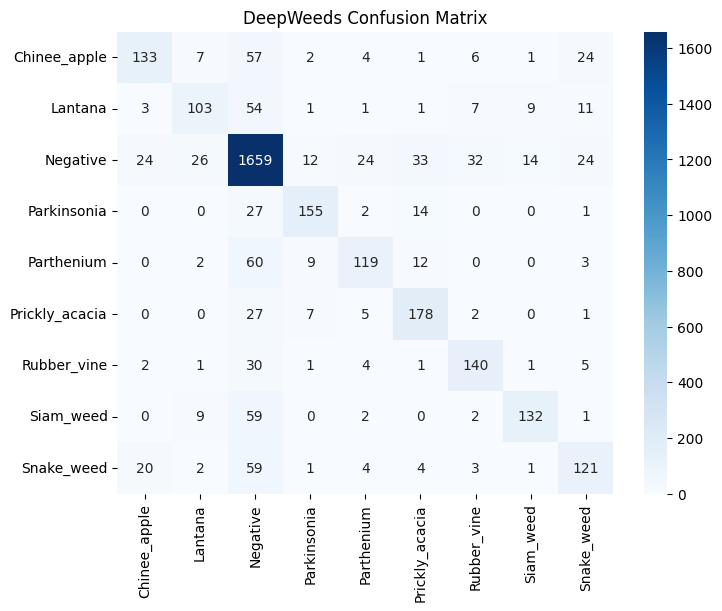

In [12]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dw_dataset.classes,
            yticklabels=dw_dataset.classes)
plt.title("DeepWeeds Confusion Matrix")
plt.show()


In [13]:
fer_train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

fer_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])


In [14]:
fer_train = datasets.ImageFolder(fer_train_path, fer_train_transform)
fer_test  = datasets.ImageFolder(fer_test_path, fer_test_transform)

train_loader_fer = DataLoader(fer_train, batch_size=32, shuffle=True)
test_loader_fer  = DataLoader(fer_test, batch_size=32, shuffle=False)

num_classes_fer = len(fer_train.classes)
print("FER classes:", num_classes_fer)


FER classes: 7


In [15]:
from torchvision.models import resnet18

model_fer = resnet18(weights=None)

# 1. Freeze entire network
for param in model_fer.parameters():
    param.requires_grad = False

# 2. Unfreeze LAST convolution block
for param in model_fer.layer4.parameters():
    param.requires_grad = True

# 3. Replace classifier
model_fer.fc = nn.Linear(model_fer.fc.in_features, num_classes_fer)

model_fer = model_fer.to(device)


In [16]:
criterion_fer = nn.CrossEntropyLoss()

optimizer_fer = optim.Adam(
    filter(lambda p: p.requires_grad, model_fer.parameters()),
    lr=1e-4
)


In [17]:
epochs = 5

for epoch in range(epochs):
    model_fer.train()
    correct = total = 0

    for imgs, labels in train_loader_fer:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer_fer.zero_grad()
        outputs = model_fer(imgs)
        loss = criterion_fer(outputs, labels)
        loss.backward()
        optimizer_fer.step()

        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    print(f"Epoch {epoch+1}: Accuracy = {correct/total:.4f}")


Epoch 1: Accuracy = 0.3196
Epoch 2: Accuracy = 0.3931
Epoch 3: Accuracy = 0.4327
Epoch 4: Accuracy = 0.4532
Epoch 5: Accuracy = 0.4680


In [18]:
model_fer.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader_fer:
        outputs = model_fer(imgs.to(device))
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=fer_train.classes))


              precision    recall  f1-score   support

       angry       0.31      0.35      0.33       958
     disgust       0.00      0.00      0.00       111
        fear       0.34      0.18      0.23      1024
       happy       0.45      0.89      0.60      1774
     neutral       0.50      0.32      0.39      1233
         sad       0.40      0.20      0.27      1247
    surprise       0.65      0.53      0.59       831

    accuracy                           0.44      7178
   macro avg       0.38      0.35      0.34      7178
weighted avg       0.43      0.44      0.41      7178



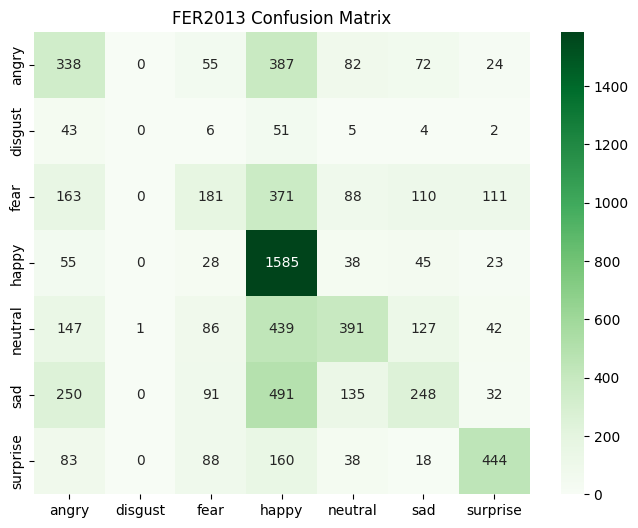

In [19]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=fer_train.classes,
            yticklabels=fer_train.classes)
plt.title("FER2013 Confusion Matrix")
plt.show()
